<a href="https://colab.research.google.com/github/shailavij/ML-Projects/blob/master/Air_Pollution__MultiTime_Series_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import all pacakages

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense , LSTM
seed= 7
np.random.seed(seed)



Mounted at /content/drive


Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Problem Statement: Given the weather conditions and pollution datas for prior hours - Beijing , we forecast the pollution at the next hour.

In [0]:
df1=pd.read_csv('drive/My Drive/DL_DATASet/raw.csv')
df1.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


# consolidate the date-time information into a single date-time so that we can use it as an index in Pandas

In [0]:
from datetime import datetime
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

df1 = pd.read_csv('drive/My Drive/DL_DATASet/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
df1.head(10)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,6,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,7,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,8,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,9,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [0]:
# Check for NAN & missing value

df1.isnull().sum()

No          0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [0]:
# drop "No" Column in dataset
df1=df1.drop("No",axis=1)
df1.shape





(43824, 8)

In [0]:
# Manually specify data column

#df1.shape
df1.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df1.index.name='Date'
df1.head(10)


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
Date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [0]:
# fill NA with 0
df1.fillna(0,inplace=True)
# Drop all NA in first 24 hours of all days
df1=df1[24:]
# Summarize first 5 rows
df1.head(5)
# Save to file
df1.to_csv("pollution.csv")

In [0]:
df1.isnull().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

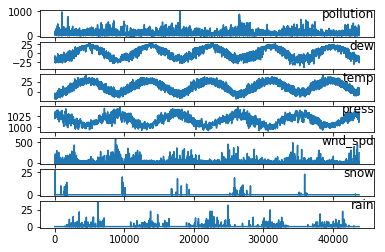

In [0]:
# EDA 
#plots each series as a separate subplot, except wind wnd_dir, which is categorical.

values= df1.values
# specify columns to plot
groups=[0,1,2,3,5,6,7]
i = 1
# plot each column
plt.figure()
for s in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, s])
	plt.title(df1.columns[s], y=0.5, loc='right')
	i += 1
plt.show()

##Multivariate LSTM Forecast Model

In [0]:
##preprocess the wind direction with label encoding
from sklearn.preprocessing import LabelEncoder
values=df1.values
encoder= LabelEncoder()

values[:,4]= encoder.fit_transform(values[:,4])
values[:,4]
print(values[:,4])


[2 2 2 ... 1 1 1]


In [0]:
## check all data is float
values=values.astype('float32')


# normalize feature
# scale the data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
norm= scaler.fit_transform(values)
norm[0:5]


array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ],
       [0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
        0.00533197, 0.        , 0.        ],
       [0.18209255, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00839101, 0.03703704, 0.        ],
       [0.13883299, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00991199, 0.07407407, 0.        ]], dtype=float32)

In [0]:

# convert times series into supervised form 

def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data
  

In [0]:
timeSteps = 2

supervised = to_supervised(norm,lag=timeSteps)
pd.DataFrame(supervised).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
1,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
2,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
3,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658
4,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0,0.105634


#Define and Fit Model

In [0]:

# spiltting the data
# training on only first year data
features=df1.shape[1]
n_train_hr=365*24
#train= values[:n_train_hr,:]
#test = values[n_train_hr:,:]

X = supervised[:,:features*timeSteps]
Y = supervised[:,features*timeSteps]

x_train = X[:n_train_hr,:]
x_test = X[n_train_hr:,:]
y_train = Y[:n_train_hr]
y_test = Y[n_train_hr:]

print (x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(8760, 16) (8760,) (35038, 16) (35038,)


In [0]:
##convert data to fit for lstm
# reshape input to be 3D [samples, timesteps, features]

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

print( x_train.shape,x_test.shape)

(8760, 2, 8) (35038, 2, 8)


In [0]:

#define the model

model = Sequential()
model.add( LSTM( 50, input_shape = ( x_train.shape[1],x_train.shape[2]) ) )
model.add( Dense(1) )

model.compile( loss = "mae", optimizer = "adam")

history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 50 , batch_size = 72, verbose = 2, shuffle = False)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8760 samples, validate on 35038 samples
Epoch 1/50
 - 8s - loss: 0.0446 - val_loss: 0.0632
Epoch 2/50
 - 3s - loss: 0.0259 - val_loss: 0.0434
Epoch 3/50
 - 3s - loss: 0.0194 - val_loss: 0.0198
Epoch 4/50
 - 3s - loss: 0.0177 - val_loss: 0.0170
Epoch 5/50
 - 3s - loss: 0.0176 - val_loss: 0.0163
Epoch 6/50
 - 3s - loss: 0.0174 - val_loss: 0.0165
Epoch 7/50
 - 3s - loss: 0.0172 - val_loss: 0.0158
Epoch 8/50
 - 3s - loss: 0.0170 - val_loss: 0.0157
Epoch 9/50
 - 3s - loss: 0.0170 - val_loss: 0.0155
Epoch 10/50
 - 3s - loss: 0.0166 - val_loss: 0.0153
Epoch 11/50
 - 3s - loss: 0.0163 - val_loss: 0.0152
Epoch 12/50
 - 3s - loss: 0.0162 - val_loss: 0.0151
Epoch 13/50
 - 3s - loss: 0.0160 - val_loss: 0.0148
Epoch 14/50
 - 3s - loss: 0.0157 - val_loss: 0.0146
Epoch 15/50
 - 3s - loss: 0.0155 - val_loss: 0.0142
Epoch 16/50
 - 3s - loss: 0.0153 - val_loss: 0.0141
Epoch 17/50
 - 3s - loss: 0.

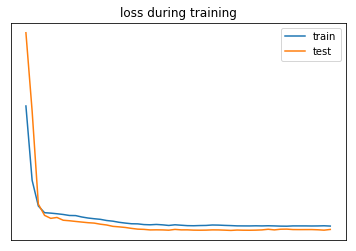

In [0]:
## plot history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yticks([])
plt.xticks([])
plt.title("loss during training")
plt.show()

In [0]:
#Evaluate Model

#scale back the prediction to orginal scale

# make a prediction
y_pred = model.predict(x_test)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2]*x_test.shape[1])

# invert scaling for forecast
inv_new = np.concatenate( (y_pred, x_test[:,-7:] ) , axis =1)
inv_new = scaler.inverse_transform(inv_new)
final_pred = inv_new[:,0]


# invert scaling for actual
y_test = y_test.reshape( len(y_test), 1)
inv_new = np.concatenate( (y_test, x_test[:,-7:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]
                      


In [0]:
print("actual",actual_pred[0])
print("final",final_pred[0])

actual 20.0
final 30.332779


In [0]:
# calculate RMSE
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(actual_pred, final_pred))
print('Test RMSE: %.3f' % rmse)
     

Test RMSE: 26.281


In [0]:
# calculate MAE
from sklearn.metrics import mean_absolute_error

MAE = (mean_absolute_error(final_pred,actual_pred))
print('Test MAE: %.3f' % MAE)
     

Test MAE: 13.372


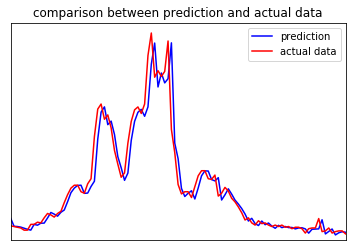

In [0]:
#plot the prediction with actual data

plt.plot(final_pred[:200], label = "prediction",c = "b")
plt.plot(actual_pred[:200],label = "actual data",c="r")
plt.xlim(0, 100)
plt.ylim(0, 300)
plt.yticks([])
plt.xticks([])
plt.title("comparison between prediction and actual data")
plt.legend()

In [0]:
final_pred[30]

164.49649

In [0]:
actual_pred[30]

155.0

In [0]:
actual_pred[:50]

array([ 20.,  19.,  18.,  17.,  14.,  14.,  22.,  22.,  25.,  24.,  31.,
        37.,  35.,  32.,  37.,  40.,  52.,  63.,  72.,  76.,  76.,  67.,
        65.,  78.,  85., 143., 181., 188., 167., 173., 155., 124., 105.,
        87.,  93., 134., 164., 180., 184., 175., 188., 255., 286., 225.,
       234., 226., 233., 275., 153., 121.], dtype=float32)